# Imports and Settings

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
import  time
from diblogeo import Geo
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

# GA Shortest Path visualisation on map

In [107]:
# Read excel with coordinates between two airports
def readFile(sheet_name, name='Points'):
    df = pd.read_excel(name+'.xlsx', 
                       index_col=0,
                       sheet_name=sheet_name)
    return df

# Generates a number of coordinates between a_point and b_point
def generateTrajectory(sheet_name, a_point, b_point, number, xlsx_name='Points'):
    df = readFile(sheet_name, xlsx_name)
    Point_A = df[df['Point'].str.contains(a_point)]
    Point_B = df[df['Point'].str.contains(b_point)]
#    print(df.loc[['VABER']])
    list_lat = np.linspace(Point_A['Lat'], Point_B['Lat'], num=number)
    list_lon = np.linspace(Point_A['Lon'], Point_B['Lon'], num=number)
    list_alt = np.linspace(Point_A['Alt'], Point_B['Alt'], num=number)
    list_speed = np.linspace(Point_A['Speed'], Point_B['Speed'], num=number)
    return list_lat, list_lon, list_alt, list_speed

# Generates a route consisting of coordX, coordY and coordZ points
def createRoute(start, finish, number):
    a = np.linspace(start, finish, num=number)
    b = np.linspace(start, finish, num=number)
    c = np.linspace(start, finish, num=number)
    X = np.random.choice(a, size=number, replace=True, p=None)
    Y = np.random.choice(b, size=number, replace=True, p=None)
    Z = np.random.choice(c, size=number, replace=True, p=None)
    # define X coordinates (algorithm goes trough each X point and selects Y with the best fit)
    X = np.linspace(start, finish, num=number)
#     Y = np.linspace(start, finish, num=number)
    Z = np.linspace(start, finish, num=number)
    # define start and finish points
    Y[start] = start
    Z[start] = finish
    Z[finish] = finish   
    X[start] = start
    Y[finish] = finish
    # Z profile between start and finish (in this case it is set to constant height line)
    Z = np.linspace(finish, finish, num=number)
    return (X,Y,Z)

# Generates a route consisting of coordX, coordY and coordZ points
def idealRoute(start, finish, number):
    # define X coordinates (algorithm goes trough each X point and selects Y with the best fit)
    X = np.linspace(start, finish, num=number)
    Y = np.linspace(start, finish, num=number)
    Z = np.linspace(start, finish, num=number)
    # define start and finish points
    Y[start] = start
    Z[start] = finish
    Z[finish] = finish   
    X[start] = start
    Y[finish] = finish
    # Z profile between start and finish (in this case it is set to constant height line)
    Z = np.linspace(finish, finish, num=number)
    return (X,Y,Z)

def initialPopulation(popSize, start, finish, number, warm_start=False):
    if (warm_start==True):
        print("loading the output.npy file ")
        population_arr = np.load('outfile.npy')
    else:
        population = []
        population.append(idealRoute(start, finish, number))
        for i in range(0, popSize):
            population.append(createRoute(start, finish, number))
            population_arr = np.asarray(population)
    return population_arr.astype(int)

def getCoordinates(arrays, number, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    lat, lon, alt, speed = generateTrajectory(sheet_name=sheet_name, 
                                       a_point=a_point, 
                                       b_point=b_point, 
                                       number=number, 
                                       xlsx_name=xlsx_name)
    list_lat, list_lon, list_alt, list_speed = [], [], [], []    
    # iterating through population members to get the real coordinate points
    for num in range (0, len(arrays)):
        for ide in range (0, len(arrays[0][0])):
#            print(arrays[num][1][ide])
            list_lat = np.append(list_lat, (lat[arrays[num][0][ide]]))
            list_lon = np.append(list_lon, (lon[arrays[num][1][ide]]))
            list_alt = np.append(list_alt, (alt[arrays[num][2][ide]]))
            list_speed = np.append(list_speed, (speed[arrays[num][2][ide]]))
    list_lat = list_lat.reshape(len(arrays),len(arrays[0][0]))
    list_lon = list_lon.reshape(len(arrays),len(arrays[0][0]))
    list_alt = list_alt.reshape(len(arrays),len(arrays[0][0]))
    list_speed = list_speed.reshape(len(arrays),len(arrays[0][0]))
    return list_lat, list_lon, list_alt, list_speed

def windParams():
    # airspeed
    WS = 10
    # ground speed
    GS = 280
    # wind direction
    alpha = 270
    return WS, GS, alpha

def windEquation(compassBearing):
    WS, GS, alpha = windParams()
    # calculate TrueAirSpeed
    TAS = np.sqrt(WS*WS+GS*GS+2*WS*GS*np.cos(alpha * np.pi / 180.))
    return TAS

def windCalculate(arrays, number, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    windCalc = []
    cBearing = []
    dist = []
    list_lat, list_lon, list_alt, list_speed = getCoordinates(arrays=arrays,
                                                  sheet_name=sheet_name, 
                                                  a_point=a_point, 
                                                  b_point=b_point, 
                                                  number=number, 
                                                  xlsx_name=xlsx_name)
    
    # iterating through real coordinate points to get distance
    for num in range (0, len(arrays)):
        for ide in range (0, len(arrays[0][0])-1):
            dist = np.append(dist, Geo((list_lat[num][ide].tolist(), 
                                                list_lon[num][ide].tolist(), 
                                                list_alt[num][ide].tolist()*1000)).distance((list_lat[num][ide+1].tolist(), 
                                                                                             list_lon[num][ide+1].tolist(),
                                                                                             list_alt[num][ide+1].tolist()*1000)))
    # total distance between a_point and b_point through generated points 
    pre_dist = dist.reshape(len(arrays), len(arrays[0][0])-1)
    
    for num in range (0, len(arrays)):
        for ide in range (0, len(arrays[0][0])-1):
            cBearing = compassBearing((list_lat[num][ide].tolist(), list_lon[num][ide].tolist()), 
                                                           (list_lat[num][ide+1].tolist(), list_lon[num][ide+1].tolist()))
            TAS = windEquation(cBearing)
            windCalc = np.append(windCalc, TAS)        
    pre_wind = windCalc.reshape(len(arrays), len(arrays[0][0])-1)
    wind = np.sum(np.divide(pre_dist, pre_wind), axis=1)
    return wind
# calculate distance between points in a grid
def distanceCalculate(arrays, number, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    distance = []    
    list_lat, list_lon, list_alt, list_speed = getCoordinates(arrays=arrays,
                                                  sheet_name=sheet_name, 
                                                  a_point=a_point, 
                                                  b_point=b_point, 
                                                  number=number, 
                                                  xlsx_name=xlsx_name)
    # iterating through real coordinate points to get distance
    for num in range (0, len(arrays)):
        for ide in range (0, len(arrays[0][0])-1):
            distance = np.append(distance, Geo((list_lat[num][ide].tolist(), 
                                                list_lon[num][ide].tolist(), 
                                                list_alt[num][ide].tolist()*1000)).distance((list_lat[num][ide+1].tolist(), 
                                                                                             list_lon[num][ide+1].tolist(),
                                                                                             list_alt[num][ide+1].tolist()*1000)))
    # total distance between a_point and b_point through generated points 
    pre_dist = distance.reshape(len(arrays), len(arrays[0][0])-1)
    distance = np.sum(pre_dist, axis=1)
    return distance

def weatherSituation(arrays, use):
    weather = np.zeros((len(arrays[0][0]),len(arrays[0][0])), dtype=int)
#    weather = np.zeros((5,6), dtype=int)
#    weather = np.zeros((6,6), dtype=int)
    if (use==True):
        weather[1][1] = 1e6
        weather[1][2] = 1e6
#         weather[3][5] = 1e6
        weather[2][1] = 1e6
        weather[2][2] = 1e6
#         weather[4][5] = 1e6
#         weather[5][3] = 1e6
#         weather[5][4] = 1e6
#         weather[5][5] = 1e6
#    weather[2][3] = 0
    return weather

def weatherCalculate(arrays, use):
    #define the weather situation (later replace with function input)
    weather = weatherSituation(arrays, use)
    weather_score = []
    for num in range (0, len(arrays)):
        weather2 = []
        for id in range(0,(len(arrays[0][0]))-1):
            weather3 = (weather[arrays[num][0][id].astype(int)][arrays[num][1][id].astype(int)])
            weather2 = np.append(weather2, weather3)
        weather_sum = np.sum(weather2)
        weather_score = np.append(weather_score, weather_sum)
    return weather_score

def fitnessScore(arrays, number, use, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    fitness = np.array([])
    distance = distanceCalculate(arrays=arrays, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    weather = weatherCalculate(arrays, use)
    wind = windCalculate(arrays=arrays, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
#     wind *= 1/wind.max()
#     print(wind)
    fitness = 1/(wind+weather)
#    fitness = 1/(distance+weather)
    return fitness

def fitnessDist(arrays, number, use, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    fitness = np.array([])
    distance = distanceCalculate(arrays=arrays, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    fitness = 1/(distance)
    return fitness

import heapq

def Selection(arrays, number, use, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    sorted_arrays = np.sort(fitnessScore(arrays=arrays, use=use, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name))
    largestFitness = (sorted_arrays[-1], sorted_arrays[-2])
    if (largestFitness[0] == largestFitness[1]):
        largestindexes1 = np.where(fitnessScore(arrays=arrays, number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name) == largestFitness[0])
        largestindexes2 = np.where(fitnessScore(arrays=arrays, number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name) == largestFitness[1])
        largestindexes1 = np.array([largestindexes1[0][0]])
        largestindexes2 = np.array([largestindexes2[0][0]])
    else:
        largestindexes1 = np.where(fitnessScore(arrays=arrays, number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name) == largestFitness[0])
        largestindexes2 = np.where(fitnessScore(arrays=arrays, number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name) == largestFitness[1])
        largestindexes1 = np.array([largestindexes1[0][0]])
        largestindexes2 = np.array([largestindexes2[0][0]])
    population1 = (arrays[largestindexes1])
    population2 = (arrays[largestindexes2])
    return (largestindexes1, largestindexes2)

# Give two best arrays to Crossover(arrays) and make mutations, 
# then return childs and append to population if their 
# fitness score is better (larger)
def Crossover(array1, array2, number):
    rand = np.random.randint(1, array1[0][0].size-1)    
    # do crossover for X Y and Z, (inefective coppying..)
#    array1[0][0][1:rand], array2[0][0][1:rand] = array2[0][0][1:rand].copy(), array1[0][0][1:rand].copy()
    array1[0][1][1:rand], array2[0][1][1:rand] = array2[0][1][1:rand].copy(), array1[0][1][1:rand].copy()
#    array1[0][2][1:rand], array2[0][2][1:rand] = array2[0][2][1:rand].copy(), array1[0][2][1:rand].copy()
    
    # do mutation (inefective coppying..)    
    rand2 = np.random.randint(0, array1[0][0].size)
    rand3 = np.random.randint(0, array1[0][0].size) 
    rand4 = np.random.randint(0, number)
    rand5 = np.random.randint(0, number)
    rand6 = np.random.randint(0, number)
    rand7 = np.random.randint(0, number)
    rand8 = np.random.randint(0, number)
    rand9 = np.random.randint(0, number)
    if (rand2 < rand3):
 #       array1[0][0][rand2+1:rand3-1], array2[0][0][rand2+1:rand3-1] = rand4, rand5
        array1[0][1][rand2+1:rand3-1], array2[0][1][rand2+1:rand3-1] = rand6, rand7
#        array1[0][2][rand2+1:rand3-1], array2[0][2][rand2+1:rand3-1] = rand8, rand9
    else:
 #       array1[0][0][rand3+1:rand2-1], array2[0][0][rand3+1:rand2-1] = rand4, rand5
        array1[0][1][rand3+1:rand2-1], array2[0][1][rand3+1:rand2-1] = rand6, rand7
#        array1[0][2][rand3+1:rand2-1], array2[0][2][rand3+1:rand2-1] = rand8, rand9
    # do mutation (inefective coppying..)    
    rand2 = np.random.randint(0, array1[0][0].size)
    rand3 = np.random.randint(0, array1[0][0].size) 
    rand4 = np.random.randint(0, number)
    rand5 = np.random.randint(0, number)
    rand6 = np.random.randint(0, number)
    rand7 = np.random.randint(0, number)
    rand8 = np.random.randint(0, number)
    rand9 = np.random.randint(0, number)
    if (rand2 < rand3):
 #       array1[0][0][rand2+1:rand3-1], array2[0][0][rand2+1:rand3-1] = rand4, rand5
        array1[0][1][rand2+1:rand3-1], array2[0][1][rand2+1:rand3-1] = rand6, rand7
#        array1[0][2][rand2+1:rand3-1], array2[0][2][rand2+1:rand3-1] = rand8, rand9
    else:
 #       array1[0][0][rand3+1:rand2-1], array2[0][0][rand3+1:rand2-1] = rand4, rand5
        array1[0][1][rand3+1:rand2-1], array2[0][1][rand3+1:rand2-1] = rand6, rand7
#        array1[0][2][rand3+1:rand2-1], array2[0][2][rand3+1:rand2-1] = rand8, rand9
    rand2 = np.random.randint(0, array1[0][0].size)
    rand3 = np.random.randint(0, array1[0][0].size) 
    rand4 = np.random.randint(0, number)
    rand5 = np.random.randint(0, number)
    rand6 = np.random.randint(0, number)
    rand7 = np.random.randint(0, number)
    rand8 = np.random.randint(0, number)
    rand9 = np.random.randint(0, number)
    if (rand2 < rand3):
 #       array1[0][0][rand2+1:rand3-1], array2[0][0][rand2+1:rand3-1] = rand4, rand5
        array1[0][1][-2], array2[0][1][-2] = rand6, rand7
#        array1[0][2][rand2+1:rand3-1], array2[0][2][rand2+1:rand3-1] = rand8, rand9
    else:
 #       array1[0][0][rand3+1:rand2-1], array2[0][0][rand3+1:rand2-1] = rand4, rand5
        array1[0][1][-2], array2[0][1][-2] = rand6, rand7
#        array1[0][2][rand3+1:rand2-1], array2[0][2][rand3+1:rand2-1] = rand8, rand9
    crossover = (array1, array2)
    
    rand2 = np.random.randint(0, array1[0][0].size)
    rand3 = np.random.randint(0, array1[0][0].size) 
    rand4 = np.random.randint(0, number)
    rand5 = np.random.randint(0, number)
    rand6 = np.random.randint(0, number)
    rand7 = np.random.randint(0, number)
    rand8 = np.random.randint(0, number)
    rand9 = np.random.randint(0, number)
    if (rand2 < rand3):
 #       array1[0][0][rand2+1:rand3-1], array2[0][0][rand2+1:rand3-1] = rand4, rand5
        array1[0][1][2], array2[0][1][2] = rand6, rand7
#        array1[0][2][rand2+1:rand3-1], array2[0][2][rand2+1:rand3-1] = rand8, rand9
    else:
 #       array1[0][0][rand3+1:rand2-1], array2[0][0][rand3+1:rand2-1] = rand4, rand5
        array1[0][1][2], array2[0][1][2] = rand6, rand7
#        array1[0][2][rand3+1:rand2-1], array2[0][2][rand3+1:rand2-1] = rand8, rand9
    crossover = (array1, array2)
    
    return np.squeeze(crossover)

# Genetic algorithm (later for -> while and move to function with some stop condition)
def geneticAlgorithm(population, counts, number, use, save_output=True, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    index=[]
    score=[]
    for i in range(0, counts):
        bestmembers = Selection(population, number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
        child = Crossover(population[bestmembers[0]], population[bestmembers[1]], number)        
                
        fitnessScoreChild = fitnessScore(child, number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
        fitnessScorePopulation = fitnessScore(population, number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
 
        index.append(i)
        score.append(max(fitnessScore(population, number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)))
        
        index_worst_pop = np.argmin(fitnessScorePopulation)
        index_best_fit = np.argmax(fitnessScoreChild)
          
        if (fitnessScoreChild[index_best_fit] > fitnessScorePopulation[index_worst_pop]):
            population = np.delete(population, index_worst_pop, axis=0)
            population = np.concatenate((population, [child[index_best_fit]]), axis=0)
        else:
            continue
        # Breake the loop if no improvement per 100 last iterations
        if (i >= 201):
            if (score[i-200] == score[i]):
                break;
            
    if (save_output==True):
        print ("saving the output to output.npy file")
        if (saveOutput(population)==True):
            print("output.npy file saved")
            
           
        
    return population, index, score

# Saves output as numpy array
def saveOutput(array):
    np.save('outfile.npy', array)
    return True

def plottingResults(initPop, population, use, index, score, number, sheet_name, a_point, b_point, xlsx_name):
    initPopfitnessScore = fitnessScore(initPop, number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    PopfitnessScore = fitnessScore(population, number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    initDistance = distanceCalculate(initPop, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    preFinalDistance = distanceCalculate(population, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    print ("init Pop Cost Function max. value: ", np.max(initPopfitnessScore), "\n")
    print ("init Pop Distance to Target", np.min(initDistance))
    fig = pyplot.figure()
    ax = Axes3D(fig)
    plt.title("Best member of initial population")
    ax.plot(initPop[np.argmax(initPopfitnessScore)][0], 
            initPop[np.argmax(initPopfitnessScore)][1], 
            initPop[np.argmax(initPopfitnessScore)][2])
    pyplot.show()

    print ("Cost Function max. value: ", np.max(PopfitnessScore), "\n")
    print ("Distance to Target", np.min(preFinalDistance))

    fig = pyplot.figure()
    ax1 = Axes3D(fig)
    ax1.plot(population[np.argmax(PopfitnessScore)][0], 
             population[np.argmax(PopfitnessScore)][1], 
             population[np.argmax(PopfitnessScore)][2])
    if use==True:
        weatherX=[1,1,2,2]
        weatherY=[1,2,1,2]
        weatherZ=[number-1, number-1, number-1, number-1]
        ax1.scatter(weatherX, weatherY, weatherZ)
    pyplot.show()
    
    plt.plot(index, score)
    
    return True

import datetime

def coordinateDistance(list_lat, list_lon, list_alt):
    paths_distance = []
    list_lat = list_lat.tolist()
    list_lon = list_lon.tolist()
    list_alt = list_alt.tolist()
    for ide in range (0, len(list_lat)-1):
        paths_distance = np.append(paths_distance, Geo((list_lat[ide], list_lon[ide], list_alt[ide]*1000))
                             .distance((list_lat[ide+1], list_lon[ide+1], list_alt[ide+1])))
    paths_distance = paths_distance.reshape(1,len(list_lat)-1)
#    distance = np.sum(pre_dist, axis=1)
    return paths_distance

def compassBearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing


def programRoutines(start=0, finish=6, number=7, use=True, initPopSize=15, counts=700, sheet_name='WAW-VNO', 
                    a_point='EPWA', b_point='VABER', xlsx_name='Points', warm_start=True, save_output=True):
    df_routines = pd.DataFrame()
#lat, lon, alt = generateTrajectory(sheet_name ='WAW-VNO', a_point='EPWA', b_point='VABER', number=5, xlsx_name ='Points')
    initPop = initialPopulation(popSize=initPopSize, start=start, finish=finish, number=number, warm_start=warm_start)
    population, index, score = geneticAlgorithm(initPop, number=number, use=use, counts=counts, save_output=save_output, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    plottingResults(initPop, population, use, index, score, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    PopfitnessScore = fitnessScore(population,  number=number, use=use, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    df_routines = distanceCalculate([population[np.argmax(PopfitnessScore)]], number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    
    return population[np.argmax(PopfitnessScore)]



In [99]:
# duomenys = pd.DataFrame(columns=['data'])
pointB = (52.209454, 21.067548)
pointA = (54.180607, 23.418109)
Bearing = compassBearing(pointA, pointB)
print(Bearing)

216.4886121140496


init Pop Cost Function max. value:  1.646992963179285 

init Pop Distance to Target 170.11518615209704


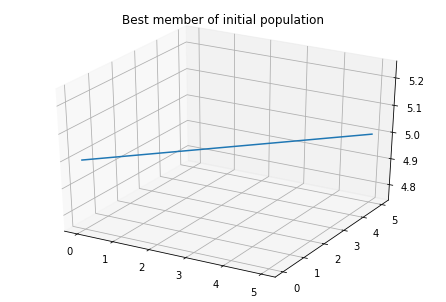

Cost Function max. value:  1.646992963179285 

Distance to Target 170.11518615209704


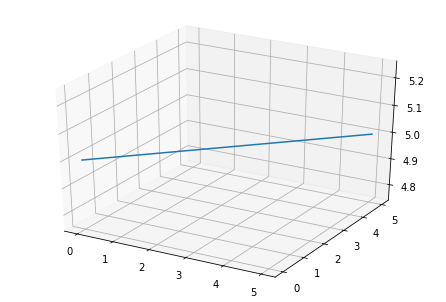

init Pop Cost Function max. value:  8.342796402291853 

init Pop Distance to Target 33.583285628961306


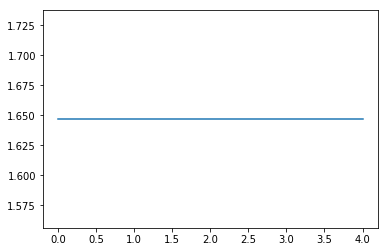

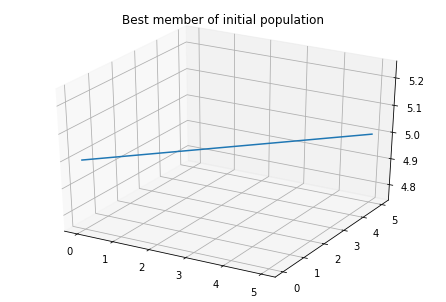

Cost Function max. value:  8.342796402291853 

Distance to Target 33.583285628961306


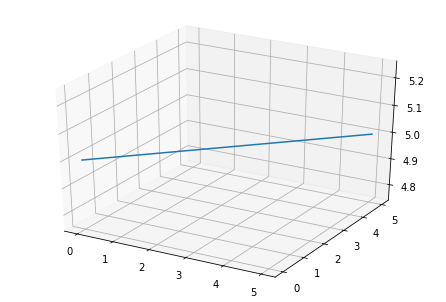

init Pop Cost Function max. value:  1.008623856339295 

init Pop Distance to Target 277.78295423163934


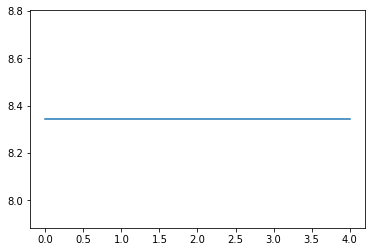

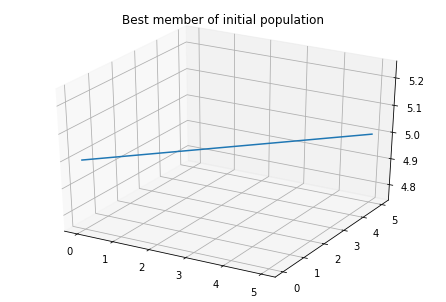

Cost Function max. value:  1.008623856339295 

Distance to Target 277.78295423163934


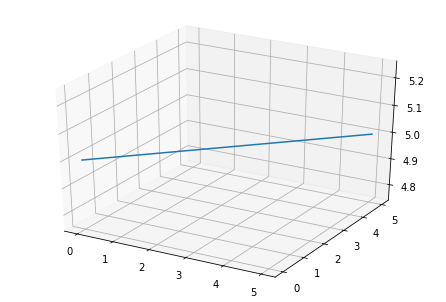

loading the output.npy file 
init Pop Cost Function max. value:  1.4904128491064648 

init Pop Distance to Target 187.98718401442335


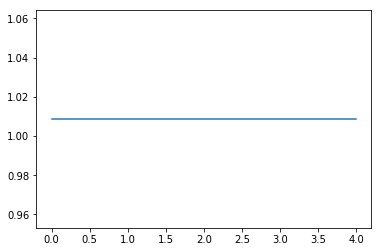

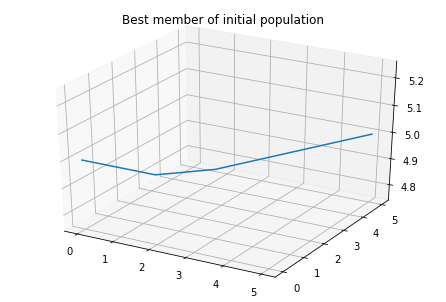

Cost Function max. value:  1.4904128491064648 

Distance to Target 187.98718401442335


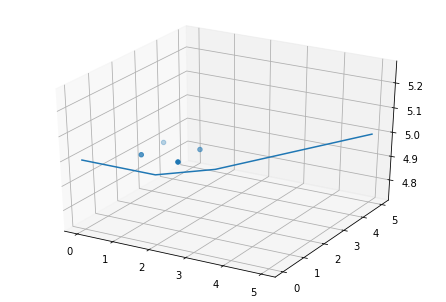

loading the output.npy file 
init Pop Cost Function max. value:  7.950032480126552 

init Pop Distance to Target 35.242436458319716


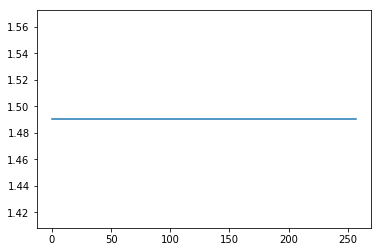

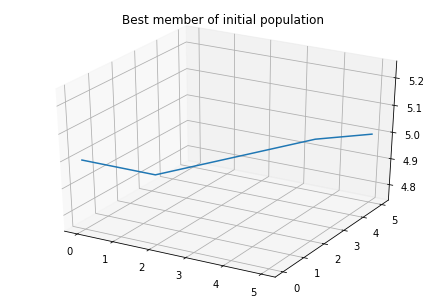

Cost Function max. value:  7.950032480126552 

Distance to Target 35.242436458319716


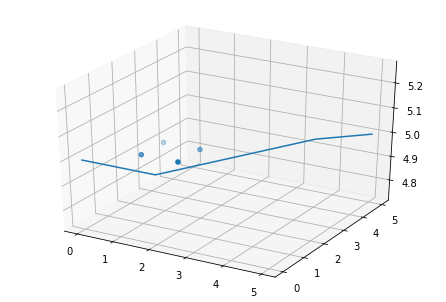

loading the output.npy file 
saving the output to output.npy file
output.npy file saved
init Pop Cost Function max. value:  0.9267697808995484 

init Pop Distance to Target 302.3172747934109


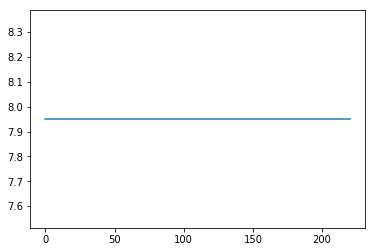

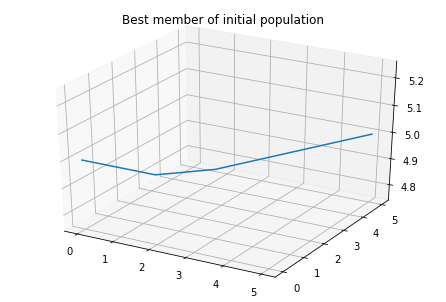

Cost Function max. value:  0.9267697808995484 

Distance to Target 302.3172747934109


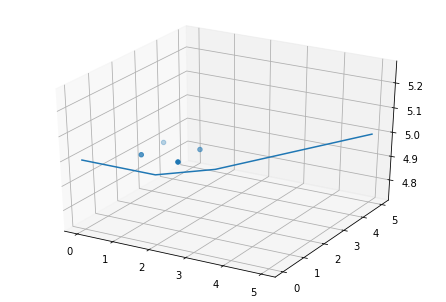

Time:  512.1673150999995


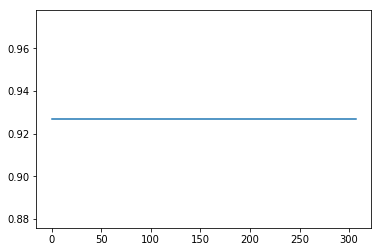

In [108]:
import timeit

start = timeit.default_timer()


points_mnsk_0 = programRoutines(start=0, 
                         finish=5, 
                         number=6, 
                         use=False,
                         initPopSize=35, 
                         counts=5, 
                         sheet_name='MNSK-VNO', 
                         a_point='UMMS', 
                         b_point='DUKAT', 
                         xlsx_name='Points',
                         warm_start=False, 
                         save_output=False)

points_ria_0 = programRoutines(start=0, 
                         finish=5, 
                         number=6, 
                         use=False,
                         initPopSize=35, 
                         counts=5, 
                         sheet_name='RIA-VNO', 
                         a_point='MURUN', 
                         b_point='VI403', 
                         xlsx_name='Points',
                         warm_start=False,
                         save_output=False)

points_waw_0 = programRoutines(start=0, 
                         finish=5, 
                         number=6, 
                         use=False,
                         initPopSize=35, 
                         counts=5, 
                         sheet_name='WAW-VNO', 
                         a_point='EPWA', 
                         b_point='VABER', 
                         xlsx_name='Points',
                         warm_start=False,
                         save_output=False)

points_mnsk_1 = programRoutines(start=0, 
                         finish=5, 
                         number=6, 
                         use=True,
                         initPopSize=35, 
                         counts=2000, 
                         sheet_name='MNSK-VNO', 
                         a_point='UMMS', 
                         b_point='DUKAT', 
                         xlsx_name='Points',
                         warm_start=True, 
                         save_output=False)

points_ria_1 = programRoutines(start=0, 
                         finish=5, 
                         number=6, 
                         use=True,
                         initPopSize=35, 
                         counts=2000, 
                         sheet_name='RIA-VNO', 
                         a_point='MURUN', 
                         b_point='VI403', 
                         xlsx_name='Points',
                         warm_start=True,
                         save_output=False)

points_waw_1 = programRoutines(start=0, 
                         finish=5, 
                         number=6, 
                         use=True,
                         initPopSize=35, 
                         counts=2000, 
                         sheet_name='WAW-VNO', 
                         a_point='EPWA', 
                         b_point='VABER', 
                         xlsx_name='Points',
                         warm_start=True,
                         save_output=True)

stop = timeit.default_timer()

print('Time: ', stop - start)  

In [101]:
subCoordinates_mnsk_0 = getCoordinates([points_mnsk_0], number=6, sheet_name='MNSK-VNO', a_point='UMMS', b_point='DUKAT', xlsx_name='Points')
subCoordinates_ria_0 = getCoordinates([points_ria_0], number=6, sheet_name='RIA-VNO', a_point='MURUN', b_point='VI403', xlsx_name='Points')
subCoordinates_waw_0 = getCoordinates([points_waw_0], number=6, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points')
subCoordinates_mnsk_1 = getCoordinates([points_mnsk_1], number=6, sheet_name='MNSK-VNO', a_point='UMMS', b_point='DUKAT', xlsx_name='Points')
subCoordinates_ria_1 = getCoordinates([points_ria_1], number=6, sheet_name='RIA-VNO', a_point='MURUN', b_point='VI403', xlsx_name='Points')
subCoordinates_waw_1 = getCoordinates([points_waw_1], number=6, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points')

np.save('saved_npy/subCoordinates2_mnsk_0.npy', subCoordinates_mnsk_0)
np.save('saved_npy/subCoordinates2_ria_0.npy', subCoordinates_ria_0)
np.save('saved_npy/subCoordinates2_ria_1.npy', subCoordinates_ria_1)
np.save('saved_npy/subCoordinates2_waw_0.npy', subCoordinates_waw_0)
np.save('saved_npy/subCoordinates2_mnsk_1.npy', subCoordinates_mnsk_1)
np.save('saved_npy/subCoordinates2_waw_1.npy', subCoordinates_waw_1)

In [90]:
display(subCoordinates_ria_0)

(array([[55.479667  , 55.44861144, 55.41755589, 55.38650033, 55.35544478,
         55.32438922]]),
 array([[24.977833  , 25.00037011, 25.02290722, 25.04544433, 25.06798144,
         25.09051856]]),
 array([[0., 0., 0., 0., 0., 0.]]),
 array([[263.33333333, 263.33333333, 263.33333333, 263.33333333,
         263.33333333, 263.33333333]]))

In [104]:
from datetime import date, datetime, time, timedelta
import datetime

df_coord = pd.DataFrame() 
df_aircrafts = pd.DataFrame() 

# table with all points in the route
def tableAllPoints(subCoordinatesName='subCoordinates_waw_0', Speed=280, sheet_name='WAW-VNO'):
    df_coord = pd.DataFrame()
    subCoordinates = np.load(subCoordinatesName+'.npy')
    df1 = pd.read_excel('Points'+'.xlsx', 
                           index_col=None,
                           sheet_name=sheet_name)

    df_leg1 = pd.read_csv('program_Output.csv')

    df2 = pd.DataFrame(data=np.squeeze(np.transpose(subCoordinates)), columns=['Lat', 'Lon', 'Alt', 'Speed'])  # 1st row as the column names
    header_list = ['Lat', 'Lon', 'Alt', 'Point', 'Speed']
    df3 = df2.reindex(columns = header_list) 
    df3[['Point', 'Speed']] = df3[['Point', 'Speed']].fillna(0)
    df3[['Point', 'Lat', 'Lon', 'Alt', 'Speed']]
    df3['Speed'] = Speed           
    if ('ria' in subCoordinatesName):
        df = (pd.concat([df1.iloc[[0,1]], df3.iloc[1:-1], df1.iloc[2:]]))
    else:
        df = (pd.concat([df1.iloc[[0]], df3.iloc[1:-1], df1.iloc[1:]]))
    df_coord = df.reset_index(drop=True)
    return df_coord

def totalDistance(df_coord):

    total_distance = pd.DataFrame(coordinateDistance(list_lat=df_coord['Lat'], 
                                                     list_lon=df_coord['Lon'], 
                                                     list_alt=df_coord['Alt']).flatten(), columns=['Paths Distance, km'])
    return total_distance

def getPath(tableAllPoints):
    df_coord = tableAllPoints
    df_coord['Paths Distance, km'] = totalDistance(tableAllPoints)
    df_coord['Paths Distance, km'] = df_coord['Paths Distance, km'].shift(1).fillna(0)
    df_coord['Leg time, hrs'] = df_coord['Paths Distance, km']/(df_coord['Speed']*1.852) 
    return df_coord

def timeAircraft(subCoordinatesName='subCoordinates_waw_1', Speed=280, sheet_name='WAW-VNO'):
    # get all points in the path:
    tablePoints = tableAllPoints(subCoordinatesName=subCoordinatesName, Speed=Speed, sheet_name=sheet_name)
    df_coord = getPath(tablePoints)
    display(df_coord)
    df_coord.to_excel('All_Routes/'+subCoordinatesName+"_RoutePoints.xlsx", sheet_name='All_routes')
    df_coord.to_pickle(subCoordinatesName+".pkl")
    # Now we need to calculate the time at finish point:
    df_aircrafts = readFile(sheet_name=sheet_name, name='Aircrafts')
    df_aircrafts['TAC'] = df_aircrafts['TAC'].apply(pd.Timestamp)  # will handle parsing
    df_aircrafts['TAC'] = pd.to_datetime(df_aircrafts['TAC'], format='%d/%m/%y %H:%M:%S')
    df_aircrafts['Weather'] = 1
    if ('1' in subCoordinatesName):
        df_aircrafts['ETC'][0:2] = df_aircrafts['TAC'].iloc[0:2] + timedelta(hours=df_coord['Leg time, hrs'].sum())
    if ('0' in subCoordinatesName):
        df_aircrafts['ETC'][2:5] = df_aircrafts['TAC'].iloc[2:5] + timedelta(hours=df_coord['Leg time, hrs'].sum())
#    display(df_aircrafts)
    return df_aircrafts

df_aircrafts = pd.DataFrame()

df_aircrafts = df_aircrafts.append(timeAircraft(subCoordinatesName='saved_npy/subCoordinates2_waw_0', Speed=280, sheet_name='WAW-VNO'))
df_aircrafts = df_aircrafts.append(timeAircraft(subCoordinatesName='saved_npy/subCoordinates2_waw_1', Speed=280, sheet_name='WAW-VNO'))
df_aircrafts = df_aircrafts.append(timeAircraft(subCoordinatesName='saved_npy/subCoordinates2_mnsk_0', Speed=280, sheet_name='MNSK-VNO'))
df_aircrafts = df_aircrafts.append(timeAircraft(subCoordinatesName='saved_npy/subCoordinates2_mnsk_1', Speed=280, sheet_name='MNSK-VNO'))
df_aircrafts = df_aircrafts.append(timeAircraft(subCoordinatesName='saved_npy/subCoordinates2_ria_1', Speed=280, sheet_name='RIA-VNO'))
df_aircrafts = df_aircrafts.append(timeAircraft(subCoordinatesName='saved_npy/subCoordinates2_ria_0', Speed=280, sheet_name='RIA-VNO'))

df_aircrafts_all = df_aircrafts
heads = ['Aircraft', 'TAC', 'ETC', 'Distance']
df_aircrafts_table = df_aircrafts[heads].dropna().reset_index(drop=True)

print("Orlaivių išvykimo laikas:")
display(df_aircrafts_table.sort_values(['TAC'], ascending=[True]))
df_aircrafts_table.to_excel("All_routes.xlsx", sheet_name='Initial_order')

df_slots = readFile(sheet_name='VNO', name='Slots')
df_slots['Slots'] = pd.to_datetime(df_slots['Slots'], format='%d/%m/%y %H:%M:%S')

df_aircrafts = df_aircrafts_table.sort_values(['ETC'], ascending=[True]).reset_index(drop=True)

display(df_slots)
display(df_aircrafts)

df_slots = df_slots.reset_index(drop=True)
df_slots['Delta, s'] = (((df_slots['Slots'])-df_aircrafts['ETC']).astype('timedelta64[s]'))
df_new = df_aircrafts.join(df_slots, how='left', lsuffix='_left', rsuffix='_right')
df_new['Speed, kt'] = (df_new['Distance']/(((df_new['Distance']/(280*1.852))+df_new['Delta, s']/3600)))/1.852
heads0 = ['Aircraft_left','TAC', 'ETC', 'Distance', 'Slots', 'Delta, s', 'Speed, kt']
heads = ['Aircraft','TAC', 'ETC', 'Distance', 'Slots', 'Delta, s', 'Speed, kt']
df_new[heads] = df_new[heads0]
display(df_new[heads])
df_new[heads].to_excel("Results.xlsx", sheet_name='Final_order')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Alt,Lat,Lon,No.,Point,Speed,"Paths Distance, km","Leg time, hrs"
0,0.0,52.165833,20.967167,1.0,EPWA,280,0.000000,0.000000
1,0.0,52.571566,21.455134,NaN,0,280,55.918608,0.107834
2,0.0,52.977300,21.943100,NaN,0,280,55.737439,0.107485
3,0.0,53.383033,22.431067,NaN,0,280,55.556412,0.107136
4,0.0,53.788767,22.919033,NaN,0,280,55.375563,0.106787
5,0.0,54.194500,23.407000,2.0,VABER,280,55.194933,0.106439
6,0.0,54.483833,24.220000,3.0,IRKAL,280,61.679285,0.118943
7,0.0,54.613833,24.849500,4.0,VI401,280,43.048186,0.083015
8,0.0,54.813667,25.057000,5.0,KOTOV,250,25.882684,0.055902
9,0.0,54.837667,25.241167,6.0,VI414,200,12.081524,0.032618


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Alt,Lat,Lon,No.,Point,Speed,"Paths Distance, km","Leg time, hrs"
0,0.0,52.165833,20.967167,1.0,EPWA,280,0.000000,0.000000
1,0.0,52.571566,20.967167,NaN,0,280,45.071874,0.086917
2,0.0,52.977300,20.967167,NaN,0,280,45.070834,0.086915
3,0.0,53.383033,21.455134,NaN,0,280,55.556412,0.107136
4,0.0,53.788767,22.431067,NaN,0,280,78.563236,0.151503
5,0.0,54.194500,23.407000,2.0,VABER,280,78.054919,0.150522
6,0.0,54.483833,24.220000,3.0,IRKAL,280,61.679285,0.118943
7,0.0,54.613833,24.849500,4.0,VI401,280,43.048186,0.083015
8,0.0,54.813667,25.057000,5.0,KOTOV,250,25.882684,0.055902
9,0.0,54.837667,25.241167,6.0,VI414,200,12.081524,0.032618


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Alt,Lat,Lon,No.,Point,Speed,"Paths Distance, km","Leg time, hrs"
0,0.0,53.882500,28.030833,1.0,UMMS,280,0.000000,0.000000
1,0.0,54.000300,27.547733,NaN,0,280,34.188549,0.065930
2,0.0,54.118100,27.064633,NaN,0,280,34.105880,0.065770
3,0.0,54.235900,26.581533,NaN,0,280,34.023124,0.065611
4,0.0,54.353700,26.098433,NaN,0,280,33.940281,0.065451
5,0.0,54.471500,25.615333,2.0,DUKAT,280,33.857353,0.065291
6,0.0,54.571167,25.632167,3.0,VI408,250,11.123378,0.024025
7,0.0,54.776167,25.667333,4.0,VI407,250,22.881576,0.049420
8,0.0,54.841167,25.573000,5.0,EKSAM,200,9.411953,0.025410
9,0.0,54.810500,25.408500,6.0,VI412,180,11.062771,0.033186


,Alt,Lat,Lon,No.,Point,Speed,"Paths Distance, km","Leg time, hrs"
0,0.0,53.882500,28.030833,1.0,UMMS,280,0.000000,0.000000
1,0.0,54.000300,28.030833,NaN,0,280,13.084829,0.025233
2,0.0,54.118100,28.030833,NaN,0,280,13.084742,0.025233
3,0.0,54.235900,27.547733,NaN,0,280,34.023124,0.065611
4,0.0,54.353700,26.581533,NaN,0,280,63.985208,0.123390
5,0.0,54.471500,25.615333,2.0,DUKAT,280,63.809282,0.123051
6,0.0,54.571167,25.632167,3.0,VI408,250,11.123378,0.024025
7,0.0,54.776167,25.667333,4.0,VI407,250,22.881576,0.049420
8,0.0,54.841167,25.573000,5.0,EKSAM,200,9.411953,0.025410
9,0.0,54.810500,25.408500,6.0,VI412,180,11.062771,0.033186


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Alt,Lat,Lon,No.,Point,Speed,"Paths Distance, km","Leg time, hrs"
0,0.0,56.923667,23.971167,1.0,EVRA,280,0.000000,0.000000
1,0.0,56.368833,24.630333,2.0,ERIVA,280,73.598535,0.141929
2,0.0,55.423767,24.977833,NaN,0,280,107.167414,0.206663
3,0.0,55.367867,24.977833,NaN,0,280,6.208653,0.011973
4,0.0,55.311967,25.058967,NaN,0,280,8.050531,0.015525
5,0.0,55.256067,25.140100,NaN,0,280,8.055160,0.015534
6,0.0,55.479667,24.977833,3.0,MURUN,280,26.864015,0.051805
7,0.0,55.200167,25.180667,4.0,VI403,250,33.583040,0.072534
8,0.0,54.883667,25.407000,5.0,GEKBI,200,37.989614,0.102564
9,0.0,54.810500,25.408500,6.0,VI412,180,8.127258,0.024380


,Alt,Lat,Lon,No.,Point,Speed,"Paths Distance, km","Leg time, hrs"
0,0.0,56.923667,23.971167,1.0,EVRA,280,0.000000,0.000000
1,0.0,56.368833,24.630333,2.0,ERIVA,280,73.598535,0.141929
2,0.0,55.423767,25.018400,NaN,0,280,107.705820,0.207702
3,0.0,55.367867,25.058967,NaN,0,280,6.715257,0.012950
4,0.0,55.311967,25.099533,NaN,0,280,6.716656,0.012953
5,0.0,55.256067,25.140100,NaN,0,280,6.718057,0.012955
6,0.0,55.479667,24.977833,3.0,MURUN,280,26.864015,0.051805
7,0.0,55.200167,25.180667,4.0,VI403,250,33.583040,0.072534
8,0.0,54.883667,25.407000,5.0,GEKBI,200,37.989614,0.102564
9,0.0,54.810500,25.408500,6.0,VI412,180,8.127258,0.024380


Orlaivių išvykimo laikas:


,Aircraft,TAC,ETC,Distance
3,SP-001,2019-02-28 12:48:00,2019-02-28 13:48:01.030259,307.514629
4,SP-002,2019-02-28 12:53:00,2019-02-28 13:53:01.030259,307.514629
0,SP-003,2019-02-28 12:55:00,2019-02-28 13:52:10.705602,277.782564
1,SP-004,2019-02-28 12:59:00,2019-02-28 13:56:10.705602,277.782564
10,YL-001,2019-02-28 13:01:30,2019-02-28 13:45:40.861577,190.390912
2,SP-005,2019-02-28 13:03:00,2019-02-28 14:00:10.705602,277.782564
11,YL-002,2019-02-28 13:03:30,2019-02-28 13:47:40.861577,190.390912
8,EW-001,2019-02-28 13:06:30,2019-02-28 13:41:46.811479,35.246334
12,YL-003,2019-02-28 13:08:30,2019-02-28 13:52:29.573615,170.115239
9,EW-002,2019-02-28 13:09:30,2019-02-28 13:44:46.811479,35.246334


,Slots,Aircraft
No.,,
1,2019-02-28 13:42:00,NaN
2,2019-02-28 13:45:00,NaN
3,2019-02-28 13:48:00,NaN
4,2019-02-28 13:51:00,NaN
5,2019-02-28 13:54:00,NaN
6,2019-02-28 13:57:00,NaN
7,2019-02-28 14:00:00,NaN
8,2019-02-28 14:03:00,NaN
9,2019-02-28 14:06:00,NaN


,Aircraft,TAC,ETC,Distance
0,EW-001,2019-02-28 13:06:30,2019-02-28 13:41:46.811479,35.246334
1,EW-002,2019-02-28 13:09:30,2019-02-28 13:44:46.811479,35.246334
2,YL-001,2019-02-28 13:01:30,2019-02-28 13:45:40.861577,190.390912
3,YL-002,2019-02-28 13:03:30,2019-02-28 13:47:40.861577,190.390912
4,SP-001,2019-02-28 12:48:00,2019-02-28 13:48:01.030259,307.514629
5,SP-003,2019-02-28 12:55:00,2019-02-28 13:52:10.705602,277.782564
6,YL-003,2019-02-28 13:08:30,2019-02-28 13:52:29.573615,170.115239
7,SP-002,2019-02-28 12:53:00,2019-02-28 13:53:01.030259,307.514629
8,SP-004,2019-02-28 12:59:00,2019-02-28 13:56:10.705602,277.782564
9,SP-005,2019-02-28 13:03:00,2019-02-28 14:00:10.705602,277.782564


,Aircraft,TAC,ETC,Distance,Slots,"Delta, s","Speed, kt"
0,EW-001,2019-02-28 13:06:30,2019-02-28 13:41:46.811479,35.246334,2019-02-28 13:42:00,13.0,265.874538
1,EW-002,2019-02-28 13:09:30,2019-02-28 13:44:46.811479,35.246334,2019-02-28 13:45:00,13.0,265.874538
2,YL-001,2019-02-28 13:01:30,2019-02-28 13:45:40.861577,190.390912,2019-02-28 13:48:00,139.0,253.356174
3,YL-002,2019-02-28 13:03:30,2019-02-28 13:47:40.861577,190.390912,2019-02-28 13:51:00,199.0,243.360212
4,SP-001,2019-02-28 12:48:00,2019-02-28 13:48:01.030259,307.514629,2019-02-28 13:54:00,358.0,239.789147
5,SP-003,2019-02-28 12:55:00,2019-02-28 13:52:10.705602,277.782564,2019-02-28 13:57:00,289.0,243.507639
6,YL-003,2019-02-28 13:08:30,2019-02-28 13:52:29.573615,170.115239,2019-02-28 14:00:00,450.0,202.746370
7,SP-002,2019-02-28 12:53:00,2019-02-28 13:53:01.030259,307.514629,2019-02-28 14:03:00,598.0,218.730839
8,SP-004,2019-02-28 12:59:00,2019-02-28 13:56:10.705602,277.782564,2019-02-28 14:06:00,589.0,214.489275
9,SP-005,2019-02-28 13:03:00,2019-02-28 14:00:10.705602,277.782564,2019-02-28 14:09:00,529.0,219.726148


Lowered zoom level to keep map size reasonable. (z = 6)


<Figure size 432x288 with 0 Axes>

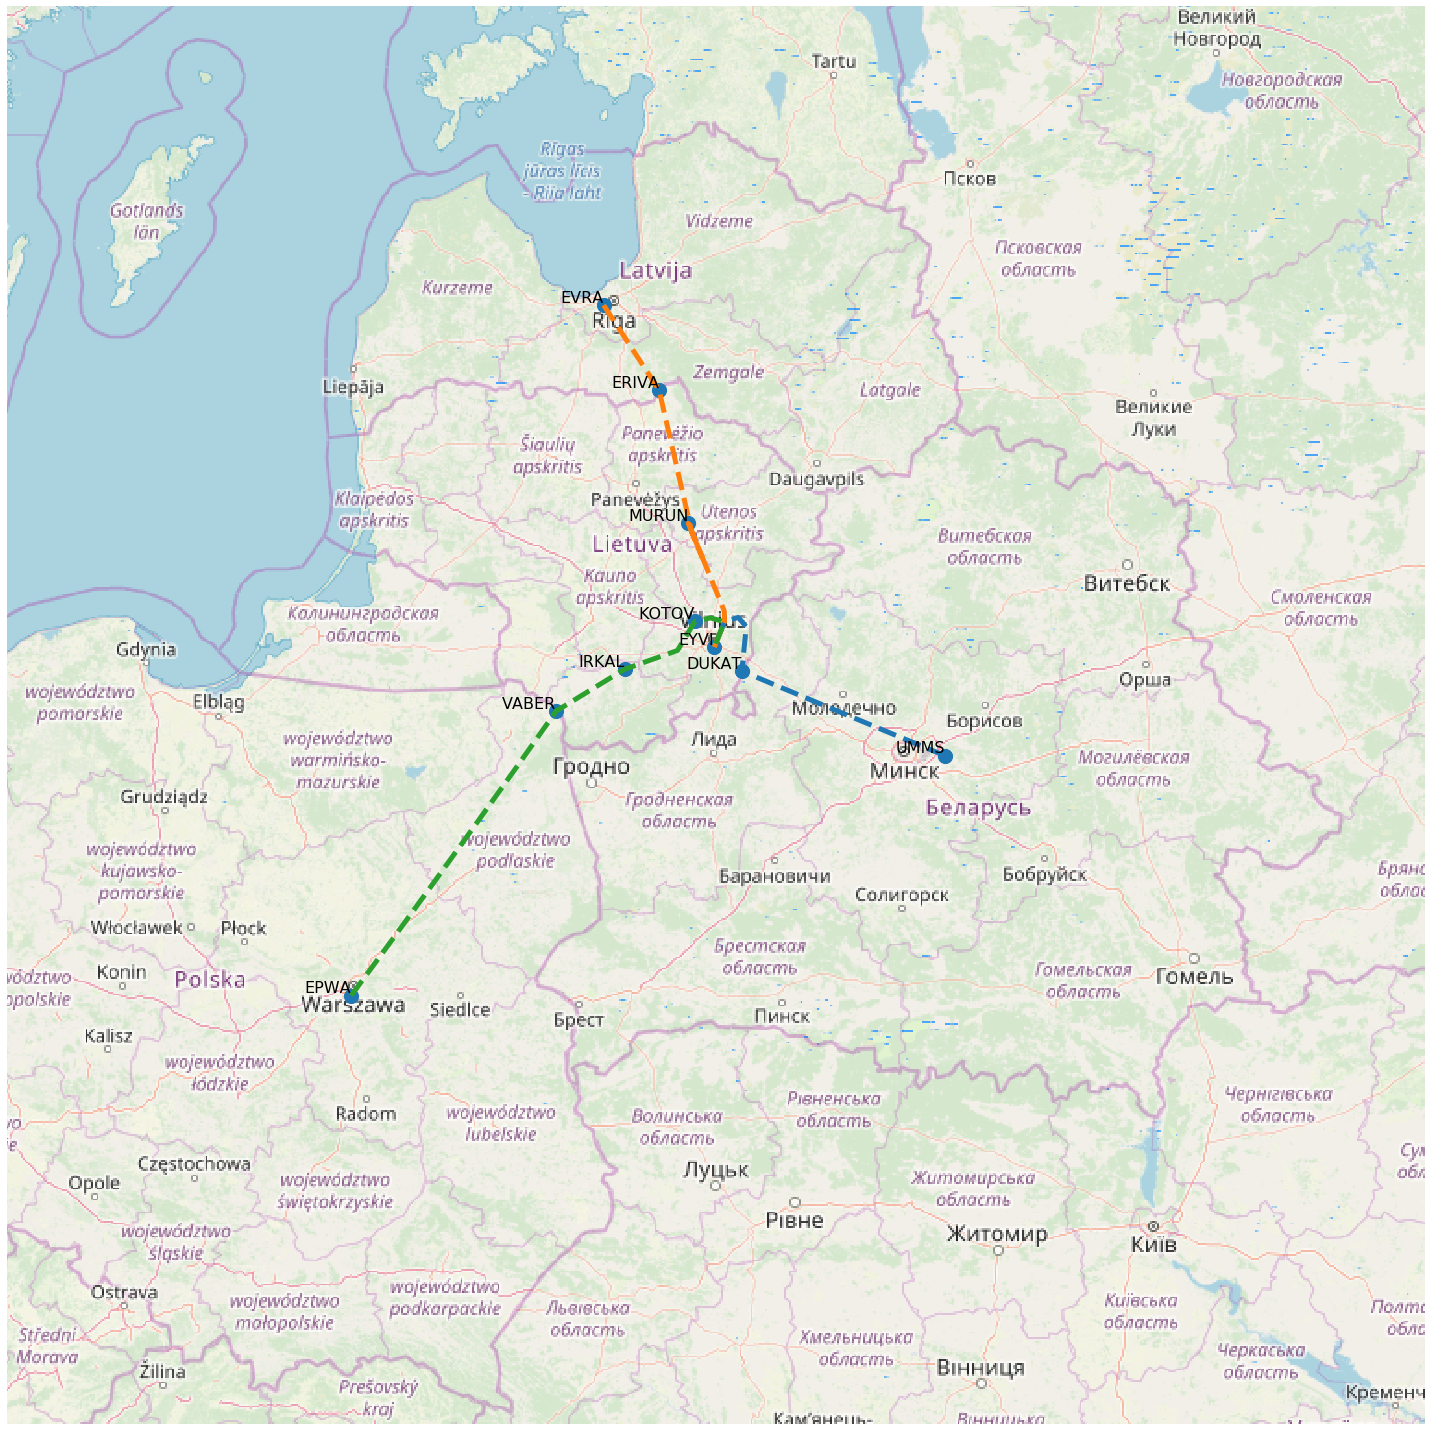

In [105]:
import smopy
import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D


df_mnsk_0 = pd.read_pickle("saved_npy/subCoordinates2_mnsk_0.pkl")
df_ria_0 = pd.read_pickle("saved_npy/subCoordinates2_ria_0.pkl")
df_waw_0 = pd.read_pickle("saved_npy/subCoordinates2_waw_0.pkl")
df_mnsk_1 = pd.read_pickle("saved_npy/subCoordinates2_mnsk_1.pkl")
df_waw_1 = pd.read_pickle("saved_npy/subCoordinates2_waw_1.pkl")

x1 = df_mnsk_0['Lat']
y1 = df_mnsk_0['Lon']

x2 = df_ria_0['Lat']
y2 = df_ria_0['Lon']

x3 = df_waw_0['Lat']
y3 = df_waw_0['Lon']

x4 = df_mnsk_1['Lat']
y4 = df_mnsk_1['Lon']

x5 = df_waw_1['Lat']
y5 = df_waw_1['Lon']

df_label = readFile(sheet_name='POINTS', name='Points')
xl5 = df_label['Lat']
yl5 = df_label['Lon']
tl5 = df_label['Point']
xl6 = df_label['Lat']
yl6 = df_label['Lon']

europe = [df_waw_0['Lat'].min(), df_waw_0['Lon'].min(), df_ria_0['Lat'].max(), 28.030833]

fig = pyplot.figure()

map = smopy.Map((europe), tileserver="https://tiles.wmflabs.org/bw-mapnik/${z}/${x}/${y}.png", tilesize=4096, maxtiles=128, z=7)

ax = map.show_mpl(figsize=(32, 20))

x1, y1 = map.to_pixels(x1, y1)
ax.plot(x1, y1, linewidth=5, linestyle='--');
x2, y2 = map.to_pixels(x2, y2)
ax.plot(x2, y2, linewidth=5, linestyle='--');
x3, y3 = map.to_pixels(x3, y3)
ax.plot(x3, y3, linewidth=5, linestyle='--');
# x4, y4 = map.to_pixels(x4, y4)
# ax.plot(x4, y4, linewidth=5);
# x5, y5 = map.to_pixels(x5, y5)
# ax.plot(x5, y5, linewidth=5);
xl5, yl5 = map.to_pixels(xl5, yl5)
for id in range(0,len(df_label.index)):
    ax.text(xl5[id+1], yl5[id+1], tl5[id+1], fontsize=16, horizontalalignment='right', verticalalignment='bottom', color='black')
xl6, yl6 = map.to_pixels(xl6, yl6)
ax.scatter(xl6, yl6, s=200, marker='o')
    
plt.savefig('map_good_weather.png', dpi=150)

Lowered zoom level to keep map size reasonable. (z = 6)


<Figure size 432x288 with 0 Axes>

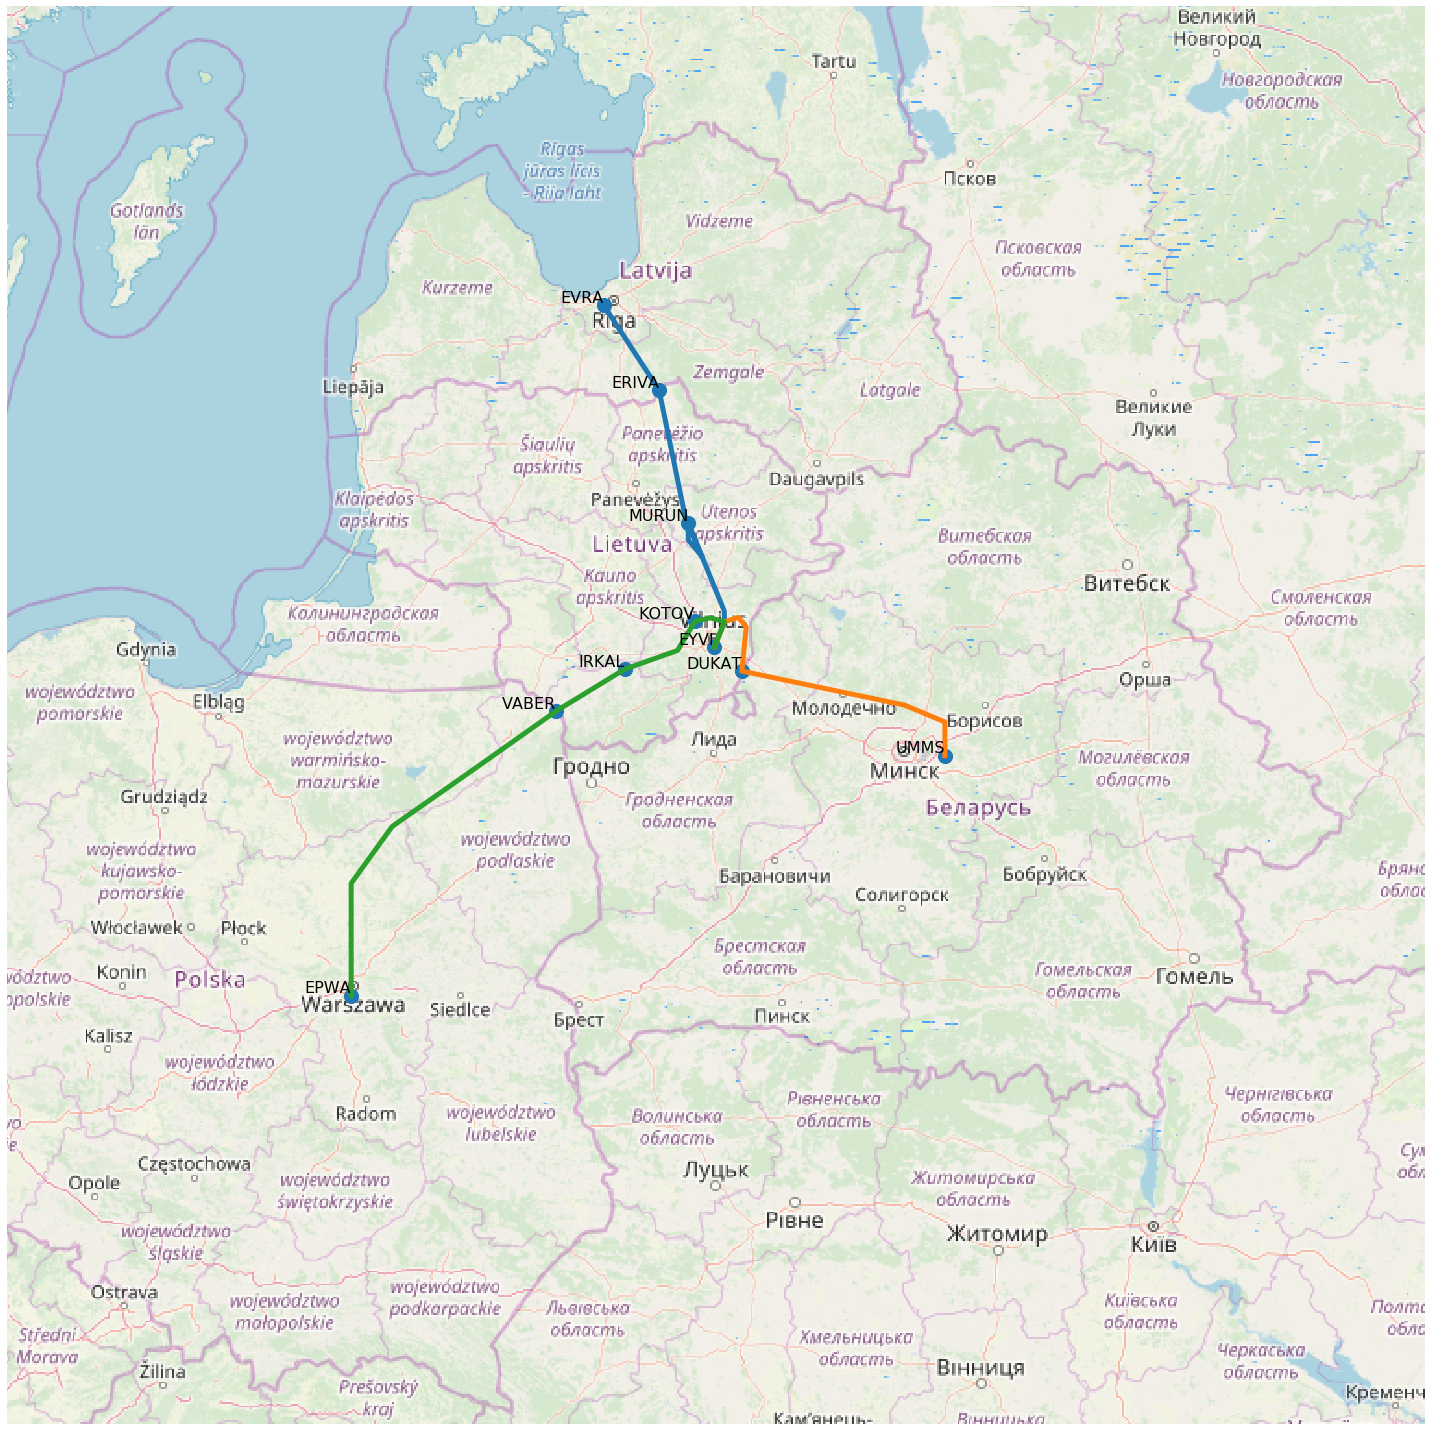

In [106]:
df_mnsk_0 = pd.read_pickle("saved_npy/subCoordinates2_mnsk_0.pkl")
df_ria_0 = pd.read_pickle("saved_npy/subCoordinates2_ria_0.pkl")
df_waw_0 = pd.read_pickle("saved_npy/subCoordinates2_waw_0.pkl")
df_mnsk_1 = pd.read_pickle("saved_npy/subCoordinates2_mnsk_1.pkl")
df_waw_1 = pd.read_pickle("saved_npy/subCoordinates2_waw_1.pkl")
df_ria_1 = pd.read_pickle("saved_npy/subCoordinates2_ria_1.pkl")

x1 = df_mnsk_0['Lat']
y1 = df_mnsk_0['Lon']

x2 = df_ria_0['Lat']
y2 = df_ria_0['Lon']

x3 = df_waw_0['Lat']
y3 = df_waw_0['Lon']

x4 = df_mnsk_1['Lat']
y4 = df_mnsk_1['Lon']

x5 = df_waw_1['Lat']
y5 = df_waw_1['Lon']

x6 = df_ria_1['Lat']
y6 = df_ria_1['Lon']

df_label = readFile(sheet_name='POINTS', name='Points')
xl5 = df_label['Lat']
yl5 = df_label['Lon']
tl5 = df_label['Point']
xl6 = df_label['Lat']
yl6 = df_label['Lon']

europe = [df_waw_0['Lat'].min(), df_waw_0['Lon'].min(), df_ria_0['Lat'].max(), 28.030833]

fig = pyplot.figure()

map = smopy.Map((europe), tileserver="https://tiles.wmflabs.org/bw-mapnik/${z}/${x}/${y}.png", tilesize=4096, maxtiles=128, z=7)

ax = map.show_mpl(figsize=(32, 20))


x6, y6 = map.to_pixels(x6, y6)
ax.plot(x6, y6, linewidth=5);
x4, y4 = map.to_pixels(x4, y4)
ax.plot(x4, y4, linewidth=5);
x5, y5 = map.to_pixels(x5, y5)
ax.plot(x5, y5, linewidth=5);
xl5, yl5 = map.to_pixels(xl5, yl5)
for id in range(0,len(df_label.index)):
    ax.text(xl5[id+1], yl5[id+1], tl5[id+1], fontsize=16, horizontalalignment='right', verticalalignment='bottom', color='black')
xl6, yl6 = map.to_pixels(xl6, yl6)
ax.scatter(xl6, yl6, s=200, marker='o')
    
plt.savefig('map_bad_weather.png', dpi=150)